In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

%matplotlib inline

In [2]:
import torch
from torch.autograd import Variable
from torch.utils import data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms

from itertools import chain
import pickle

In [3]:
faces = np.load("../../../data/quickdraw/face.npy").reshape([-1, 28, 28])
houses = np.load("../../../data/quickdraw/house.npy").reshape([-1, 28, 28])
faces.shape, houses.shape

((161666, 28, 28), (135420, 28, 28))

In [4]:
faces = (faces / 255.).astype(np.float32)
houses = (houses / 255.).astype(np.float32)

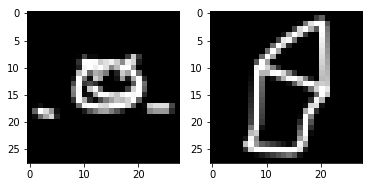

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

axes[0].imshow(faces[random.randint(0, faces.shape[0]-1)], cmap=plt.cm.gray)
axes[1].imshow(houses[random.randint(0, houses.shape[0]-1)], cmap=plt.cm.gray)

In [6]:
faces.min(), faces.max(), faces.dtype

(0.0, 1.0, dtype('float32'))

## preprocessing and dataset

In [7]:
class FaceHouseDataset(data.Dataset):
    def __init__(self, faces, houses, transform=None):
        self.faces = np.expand_dims(faces, axis=-1)
        self.houses = np.expand_dims(houses, axis=-1)
        self.transform = transform
    def __len__(self):
        return max(self.faces.shape[0], self.houses.shape[0])
    def __getitem__(self, i):
        iface = random.randint(0, self.faces.shape[0]-1)
        ihouse = random.randint(0, self.houses.shape[0]-1)
        face = self.faces[iface]
        house = self.houses[ihouse]
        if self.transform:
            face, house = self.transform(face), self.transform(house)
        return (face, house)

In [8]:
## test dataset
fh_dataset = FaceHouseDataset(faces, houses, transform=transforms.ToTensor())
face, house = fh_dataset[0]
face.size(), house.size()

(torch.Size([1, 28, 28]), torch.Size([1, 28, 28]))

## model

### discriminator

In [9]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        self.cnn1 = nn.Sequential(
            # conv1
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False), # (28-4+1*2)/2+1=14
            nn.ELU(inplace=True)
        )
        self.cnn2 = nn.Sequential(
            # conv2
            nn.Conv2d(64, 64*2, kernel_size=4, stride=2, padding=1, bias=False), #(14-4+1*2)/2+1=7
            nn.BatchNorm2d(64*2),
            nn.ELU(inplace=True),
        )
        self.cnn3 = nn.Sequential(
            # conv3
            nn.Conv2d(64*2, 64*4, kernel_size=3, stride=2, padding=1, bias=False), #(7-3+2*1)/2+1=4
            nn.BatchNorm2d(64*4),
            nn.ELU(inplace=True),
        )
        self.cnn4 = nn.Sequential(
            # conv4
            nn.Conv2d(64*4, 64*8, kernel_size=4, stride=2, padding=1, bias=False), #(4-4+2*1)/2+1=2
            nn.BatchNorm2d(64*8),
            nn.ELU(inplace=True),
        )
        self.cnn5 = nn.Sequential(
            # conv5
            nn.Conv2d(64*8, 1, kernel_size=2, stride=1, padding=0, bias=False), #(2-2+0)/1+1=1
        )
    def forward(self, x):
        out1 = self.cnn1(x)
        out2 = self.cnn2(out1)
        out3 = self.cnn3(out2)
        out4 = self.cnn4(out3)
        out = self.cnn5(out4)
        prob = F.sigmoid(out).view([x.size(0), 1])
        return prob, [out2, out3, out4]

In [10]:
## test discriminator
d = Discriminator().cuda()
x = Variable(torch.rand([16, 1, 28, 28])).cuda()
prob, feats = d(x)
prob.size()

torch.Size([16, 1])

### generator

Mapping from category A -> category B and vice versa

In [11]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            # (28-4+2)/2+1=14
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.ELU(inplace=True),
            # (14-4+2)/2+1=7
            nn.Conv2d(64, 64*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64*2),
            nn.ELU(inplace=True),
            # (7-3+2)/2+1=4
            nn.Conv2d(64*2, 64*4, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64*4),
            nn.ELU(inplace=True),
            # (4-4+2)/2+1=2
            nn.Conv2d(64*4, 64*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64*8),
            nn.ELU(inplace=True)
        )
        self.decoder = nn.Sequential(
            # (2-1)*2+4-2=4
            nn.ConvTranspose2d(64*8, 64*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64*4),
            nn.ELU(inplace=True),
            # (4-1)*2+3-2=7
            nn.ConvTranspose2d(64*4, 64*2, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64*2),
            nn.ELU(inplace=True),
            # (7-1)*2+4-2=14
            nn.ConvTranspose2d(64*2, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ELU(inplace=True),
            # (14-1)*2+4-2=28
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False)
        )
    def forward(self, x):
        out = self.encoder(x)
        out = self.decoder(out)
        out = F.sigmoid(out) # normalize to [0,1]
        return out

In [12]:
## test generator
g = Generator().cuda()
x = Variable(torch.rand([16, 1, 28, 28])).cuda()
g(x).size()

torch.Size([16, 1, 28, 28])

## train

In [13]:
batch_size = 256

generator_f2h = Generator().cuda() # face -> house
generator_h2f = Generator().cuda() # house -> face
discriminator_f = Discriminator().cuda() # face -> real/fake
discriminator_h = Discriminator().cuda() # house -> real/fake

generator_f2h.train()
generator_h2f.train()
discriminator_f.train()
discriminator_h.train()

Discriminator (
  (cnn1): Sequential (
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ELU (alpha=1.0, inplace)
  )
  (cnn2): Sequential (
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (2): ELU (alpha=1.0, inplace)
  )
  (cnn3): Sequential (
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (2): ELU (alpha=1.0, inplace)
  )
  (cnn4): Sequential (
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (2): ELU (alpha=1.0, inplace)
  )
  (cnn5): Sequential (
    (0): Conv2d(512, 1, kernel_size=(2, 2), stride=(1, 1), bias=False)
  )
)

In [14]:
reconstruction_objective = nn.MSELoss()
gan_objective = nn.BCELoss()

# feature matching feat objective helps converge
feat_objective = nn.HingeEmbeddingLoss() 
def get_feat_loss(real_feats, fake_feats):
    loss = 0
    for real_feat, fake_feat in zip(real_feats, fake_feats):
        l2 = torch.pow(real_feat.mean(0)-fake_feat.mean(0), 2)
        loss += feat_objective(l2, Variable(torch.ones(l2.size())).cuda())
    return loss

## we have to train generators together (the same with discrinators) because
## the loss depends on both encoders and decoders
generator_params = chain(generator_f2h.parameters(), generator_h2f.parameters())
discriminator_params = chain(discriminator_f.parameters(), discriminator_h.parameters())
gen_optimizer = optim.Adam(generator_params, lr=5e-4)
dis_optimizer = optim.Adam(discriminator_params, lr=5e-4)


image_pairs = data.DataLoader(fh_dataset, batch_size=batch_size, 
                              shuffle=False, num_workers=4)

In [ ]:
n_epochs = 10

iters = 0
for epoch in range(n_epochs):
    for b, (face_images, house_images) in enumerate(image_pairs):
        iters += 1
        
        ## input variables        
        f = Variable(face_images).cuda()
        h = Variable(house_images).cuda()
        
        ## generator variables
        f2h = generator_f2h(f)
        h2f = generator_h2f(h)
        
        f2h2f = generator_h2f(f2h)
        h2f2h = generator_f2h(h2f)
        
        ## discriminator variables
        f_is_f, f_feat = discriminator_f(f)
        h2f_is_f, h2f_feat = discriminator_f(h2f)
        
        h_is_h, h_feat = discriminator_h(h)
        f2h_is_h, f2h_feat = discriminator_h(f2h)
        
        n = f.size(0)
        label1 = Variable(torch.ones(n, 1)).cuda()
        label0 = Variable(torch.zeros(n, 1)).cuda()
        
        ## generator reconstruction loss
        gen_f_recon_loss = reconstruction_objective(f2h2f, f)
        gen_h_recon_loss = reconstruction_objective(h2f2h, h)
        
        ## generator gan loss
        generator_f_gan_loss = gan_objective(h2f_is_f, label1)
        generator_h_gan_loss = gan_objective(f2h_is_h, label1)
        
        ## generator feat loss
        generator_f_feat_loss = get_feat_loss(f_feat, h2f_feat)
        generator_h_feat_loss = get_feat_loss(h_feat, f2h_feat)
        
        ## generator loss
        rate = 0.01 if iters < 10000 else 0.5
        generator_f_loss = (1-rate)*(generator_f_gan_loss*0.1+generator_f_feat_loss*0.9) + rate*gen_f_recon_loss
        generator_h_loss = (1-rate)*(generator_h_gan_loss*0.1+generator_h_feat_loss*0.9) + rate*gen_h_recon_loss
        
        generator_loss = generator_f_loss + generator_h_loss
        
        ## discriminator gan loss
        discriminator_f_loss = gan_objective(f_is_f, label1)*.5 + gan_objective(h2f_is_f, label0)*.5
        discriminator_h_loss = gan_objective(h_is_h, label1)*.5 + gan_objective(f2h_is_h, label0)*.5
        
        discriminator_loss = discriminator_f_loss + discriminator_h_loss
        
        ## update
        if b % 10 == 0:
            discriminator_f.zero_grad()
            discriminator_h.zero_grad()
            discriminator_loss.backward()
            dis_optimizer.step()
        else:
            generator_f2h.zero_grad()
            generator_h2f.zero_grad()
            generator_loss.backward()
            gen_optimizer.step()
        
        ## report
        if b % 50 == 0:
            print(epoch, b, generator_loss.data[0], discriminator_loss.data[0])
            print("==>g_f_loss=%.2f, g_h_loss=%.2f, d_f_loss=%.2f, d_h_loss=%.2f" % (generator_f_loss.data[0],
                                                                                    generator_h_loss.data[0],
                                                                                    discriminator_f_loss.data[0],
                                                                                    discriminator_h_loss.data[0]))
            pickle.dump(generator_f2h.state_dict(), open("../../../models/generator_f2h.pkl", "wb"))
            pickle.dump(generator_h2f.state_dict(), open("../../../models/generator_h2f.pkl", "wb"))
            pickle.dump(discriminator_f.state_dict(), open("../../../models/discriminator_f.pkl", "wb"))
            pickle.dump(discriminator_h.state_dict(), open("../../../models/discriminator_h.pkl", "wb"))

## generation

In [13]:
generator_f2h = Generator().cuda() # face -> house
generator_h2f = Generator().cuda() # house -> face
discriminator_f = Discriminator().cuda() # face -> real/fake
discriminator_h = Discriminator().cuda() # house -> real/fake

generator_f2h.load_state_dict(torch.load(open("../../../models-bk/generator_f2h.pkl", "rb")))
generator_h2f.load_state_dict(torch.load(open("../../../models-bk/generator_h2f.pkl", "rb")))
discriminator_f.load_state_dict(torch.load(open("../../../models-bk/discriminator_f.pkl", "rb")))
discriminator_h.load_state_dict(torch.load(open("../../../models-bk/discriminator_h.pkl", "rb")))

In [14]:
generator_f2h.eval()
generator_h2f.eval()
discriminator_f.eval()
discriminator_h.eval()
p = transforms.ToPILImage()

In [18]:
face, house = fh_dataset[random.randint(0, len(fh_dataset)-1)]
face2house = generator_f2h(Variable(face).cuda()[None, ...])
house2face = generator_h2f(Variable(house).cuda()[None, ...])

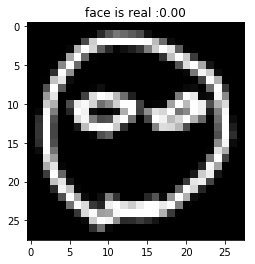

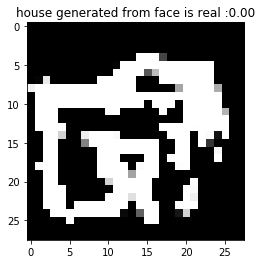

In [19]:
plt.imshow(face.numpy().squeeze(), cmap=plt.cm.gray)
plt.title("face is real :%.2f"%discriminator_f(Variable(face).cuda()[None, ...])[0].data.squeeze()[0])
plt.figure()
plt.imshow(face2house.cpu().data.numpy().squeeze(), cmap=plt.cm.gray)
plt.title("house generated from face is real :%.2f"%discriminator_h(face2house)[0].data.squeeze()[0])

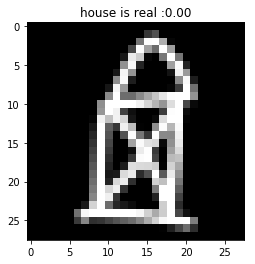

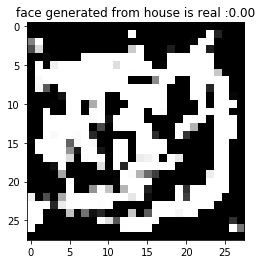

In [20]:
plt.imshow(house.numpy().squeeze(), cmap=plt.cm.gray)
plt.title("house is real :%.2f"%discriminator_h(Variable(house).cuda()[None, ...])[0].data.squeeze()[0])
plt.figure()
plt.imshow(house2face.cpu().data.numpy().squeeze(), cmap=plt.cm.gray)
plt.title("face generated from house is real :%.2f"%discriminator_h(house2face)[0].data.squeeze()[0])

In [134]:
torch.nn.LeakyReLU?